Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(6)
Number of possible actions: 6
Episode 1: Total Reward = -21.0
Episode 2: Total Reward = -19.0
Episode 3: Total Reward = -17.0
Episode 4: Total Reward = -21.0
Episode 5: Total Reward = -21.0

Average total reward over 3 random episodes: -19.8


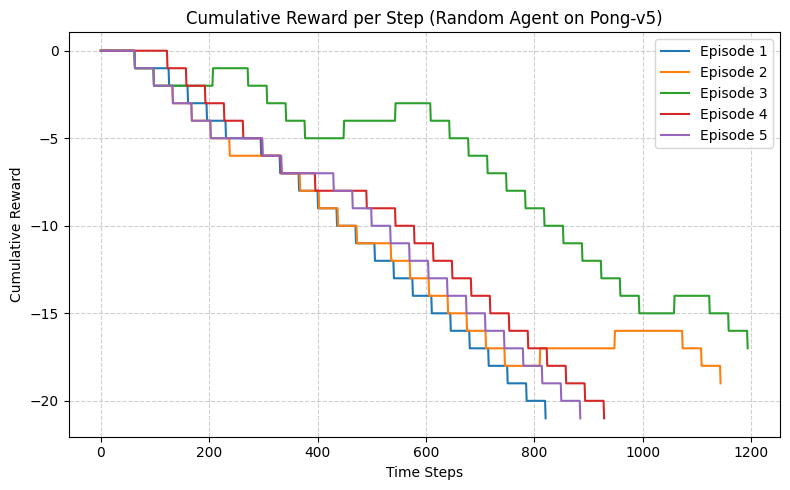

In [ ]:
import gymnasium as gym
import ale_py
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("ALE/Pong-v5", render_mode=None)  # set render_mode='human' if you want to see the game

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Number of possible actions:", env.action_space.n)

num_episodes = 5
episode_rewards = []
reward_trajectories = []  # store reward progression per episode

for ep in range(num_episodes):
    obs, info = env.reset(seed=ep)
    done = False
    total_reward = 0
    rewards = []

    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        rewards.append(total_reward)  # cumulative reward curve
        done = terminated or truncated

    episode_rewards.append(total_reward)
    reward_trajectories.append(rewards)
    print(f"Episode {ep+1}: Total Reward = {total_reward}")

env.close()


print(f"\nAverage total reward over {num_episodes} random episodes:", np.mean(episode_rewards))

plt.figure(figsize=(8, 5))
for i, rewards in enumerate(reward_trajectories):
    plt.plot(rewards, label=f'Episode {i+1}')
plt.title("Cumulative Reward per Step (Random Agent on Pong-v5)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"pong_{num_episodes}_random_agent_rewards.png")
plt.show()


In [ ]:
import gymnasium as gym
import ale_py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from collections import deque
import os

BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 1000000  # Decay over 1M steps
TARGET_UPDATE = 10000  # Update target network every 10k steps
MEMORY_SIZE = 100000
LEARNING_RATE = 0.00025
NUM_EPISODES = 2500  # Train until ~2-4M steps
MAX_STEPS_PER_EPISODE = 1500  # Cap episode length
FRAME_STACK = 4  # Stack 4 frames
INPUT_SHAPE = (84, 84)  # Downsampled size

# Preprocessing function
def preprocess_frame(frame):

    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    resized = cv2.resize(gray, INPUT_SHAPE, interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0  # Normalize to [0,1]

# DQN Network (CNN)
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_actions)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Experience Replay
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# Initialize environment
env = gym.make('ALE/Pong-v5')
num_actions = 6 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize networks
policy_net = DQN((FRAME_STACK, INPUT_SHAPE[0], INPUT_SHAPE[1]), num_actions).to(device)
target_net = DQN((FRAME_STACK, INPUT_SHAPE[0], INPUT_SHAPE[1]), num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)


def select_action(state, steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).item()
    else:
        return random.choice([0, 2, 3]) 

# Training loop with tracking for visualizations
steps_done = 0
episode_rewards = []
episode_lengths = [] 
losses = []  
eps_values = []  
best_mean_reward = -21.0 #-float('inf')

for episode in range(NUM_EPISODES):
    obs = env.reset()[0]  
    state = np.stack([preprocess_frame(obs)] * FRAME_STACK, axis=0)  
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0
    done = False
    episode_steps = 0
    episode_loss = 0  # Accumulate loss for this episode
    
    while not done and episode_steps < MAX_STEPS_PER_EPISODE:
        action = select_action(state, steps_done)
        obs, reward, terminated, truncated, _ = env.step(action)  # Note: step() still returns (obs, reward, done, info)
        total_reward += reward
        done  = terminated or truncated
        
        # Preprocess next frame and update state stack
        next_frame = preprocess_frame(obs)
        next_state_stack = np.roll(state.squeeze(0).cpu().numpy(), shift=-1, axis=0)
        next_state_stack[-1] = next_frame
        next_state = torch.tensor(next_state_stack, dtype=torch.float32, device=device).unsqueeze(0)
        
        # Store in memory
        memory.push(state, action, reward, next_state, done)
        state = next_state
        steps_done += 1
        episode_steps += 1
        
        # Train if enough samples
        if len(memory) >= BATCH_SIZE:
            transitions = memory.sample(BATCH_SIZE)
            batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)
            
            batch_state = torch.cat(batch_state)
            batch_action = torch.tensor(batch_action, device=device).unsqueeze(1)
            batch_reward = torch.tensor(batch_reward, device=device)
            batch_next_state = torch.cat(batch_next_state)
            batch_done = torch.tensor(batch_done, dtype=torch.float32, device=device)
            
            # Compute Q values
            q_values = policy_net(batch_state).gather(1, batch_action).squeeze(1)
            next_q_values = target_net(batch_next_state).max(1)[0]
            expected_q_values = batch_reward + (GAMMA * next_q_values * (1 - batch_done))
            
            # Loss and backprop
            loss = nn.MSELoss()(q_values, expected_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            episode_loss += loss.item()  # Accumulate loss
    
    episode_rewards.append(total_reward)
    episode_lengths.append(episode_steps)
    losses.append(episode_loss / episode_steps if episode_steps > 0 else 0)  # Average loss per step
    eps_values.append(EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY))  # Current epsilon
    
    # Computing mean reward over last 100 episodes
    if len(episode_rewards) >= 100:
        mean_reward = np.mean(episode_rewards[-100:])
        best_mean_reward = max(best_mean_reward, mean_reward)
        print(f"Episode {episode}, Steps: {steps_done}, Mean Reward (last 100): {mean_reward:.2f}, Best Mean: {best_mean_reward:.2f}")
    
    # Stop if trained enough
    if steps_done >= 2500000:
        break

env.close()


# 1. Learning curve
if len(episode_rewards) >= 100:
    """This curve shows how the agent's performance improves over time. Initially, rewards are negative, 
    but they should rise as the agent learns to win points. The best mean reward indicates peak performance. 
    If it plateaus, it suggests the agent has learned a decent strategy, though further tuning might help."""
    
    mean_rewards = [np.mean(episode_rewards[max(0, i-99):i+1]) for i in range(99, len(episode_rewards))]
    timesteps = np.arange(100, len(episode_rewards)+1) * 2000  # Approximate steps per episode
    
    plt.figure(figsize=(10, 5))
    plt.plot(timesteps / 1e6, mean_rewards, label='Mean Reward (last 100 episodes)')
    plt.axhline(y=best_mean_reward, color='r', linestyle='--', label=f'Best Mean Reward: {best_mean_reward:.2f}')
    plt.xlabel('Timesteps (Millions)')
    plt.ylabel('Mean Reward')
    plt.title('DQN Learning Curve for Pong')
    plt.legend()
    plt.grid()
    plt.savefig('dqn_pong_learning_curve.png')
    plt.show()

    

# 2. Epsilon decay over episodes
"""Epsilon starts high (1.0) for exploration and decays exponentially to 0.1.
Early episodes involve more random actions, while later ones rely on learned policies. 
This balance is key for DQN to avoid getting stuck in suboptimal strategies.
"""
plt.figure(figsize=(10, 5))
plt.plot(range(len(eps_values)), eps_values, color='purple')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay Over Episodes (Exploration vs. Exploitation)')
plt.grid()
plt.savefig('dqn_epsilon_decay.png')
plt.show()

# 3. Training loss over episodes
"""Loss measures how well the Q-network predicts rewards. It should decrease over time as the network learns accurate Q-values. 
Spikes might indicate exploration or hard-to-learn states. Converging loss suggests stable learning.
"""
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, color='orange')
plt.xlabel('Episode')
plt.ylabel('Average Loss per Step')
plt.title('Training Loss Over Episodes')
plt.grid()
plt.savefig('dqn_training_loss.png')
plt.show()

# 4. Episode lengths over episodes
"""Episode lengths start long (e.g., 1000+ steps) and may shorten as the agent learns to win faster. 
In Pong, shorter episodes mean the agent is scoring more efficiently. If lengths increase, it could indicate the agent is struggling.
"""
plt.figure(figsize=(10, 5))
plt.plot(range(len(episode_lengths)), episode_lengths, color='cyan')
plt.xlabel('Episode')
plt.ylabel('Episode Length (Steps)')
plt.title('Episode Lengths Over Episodes')
plt.grid()
plt.savefig('dqn_episode_lengths.png')
plt.show()

# Save the model
torch.save(policy_net.state_dict(), 'Pong-DQN.pth')
print("Model saved as 'Pong-DQN.pth'.")


ModuleNotFoundError: No module named 'gymnasium.wrappers.atari'